In [1]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad, make_jaxpr, lax
from jax import random, profiler, config, debug
from jax.nn import sigmoid
import numpy as np
import jax
from flax import struct
import optax

from larndsim.quenching_jax import quench
from larndsim.drifting_jax import drift
from larndsim.consts_jax import consts
from larndsim.pixels_from_track_jax import get_active_pixels, get_max_active_pixels, get_max_radius, get_neighboring_pixels_sp, pixels_to_sp, get_pixel_coordinates
from larndsim.detsim_jax import time_intervals, overlapping_segment, tracks_current
from numpy.lib import recfunctions as rfn

import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

In [2]:
def jax_from_structured(tracks):
    tracks_np = rfn.structured_to_unstructured(tracks, copy=True, dtype=np.float32)
    return jnp.array(tracks_np)

def load_data():
    import h5py
    with h5py.File('/home/pgranger/larnd-sim/jit_version/larnd-sim/examples/module0_corsika.h5', 'r') as f:
        tracks = np.array(f['segments'])

    x_start = np.copy(tracks['x_start'] )
    x_end = np.copy(tracks['x_end'])
    x = np.copy(tracks['x'])

    tracks['x_start'] = np.copy(tracks['z_start'])
    tracks['x_end'] = np.copy(tracks['z_end'])
    tracks['x'] = np.copy(tracks['z'])

    tracks['z_start'] = x_start
    tracks['z_end'] = x_end
    tracks['z'] = x

    selected_tracks = tracks
    fields = selected_tracks.dtype.names
    return rfn.structured_to_unstructured(tracks, copy=True, dtype=np.float32), fields

# @partial(jit, static_argnames=['fields'])
def chop_tracks(tracks, fields, precision=0.001):
    print(tracks)
    def split_track(track, nsteps, step_size, direction, i):
        new_tracks = track.reshape(1, track.size).repeat(nsteps, axis=0)

        new_tracks[:, fields.index("dE")] = new_tracks[:, fields.index("dE")]/nsteps
        steps = np.arange(0, int(nsteps))

        new_tracks[:, fields.index("x_start")] = new_tracks[:, fields.index("x_start")] + steps*step_size*direction[0]
        new_tracks[:, fields.index("y_start")] = new_tracks[:, fields.index("y_start")] + steps*step_size*direction[1]
        new_tracks[:, fields.index("z_start")] = new_tracks[:, fields.index("z_start")] + steps*step_size*direction[2]

        new_tracks[:, fields.index("x_end")] = new_tracks[:, fields.index("x_end")] + step_size*(steps + 1)*direction[0]
        new_tracks[:, fields.index("y_end")] = new_tracks[:, fields.index("y_end")] + step_size*(steps + 1)*direction[1]
        new_tracks[:, fields.index("z_end")] = new_tracks[:, fields.index("z_end")] + step_size*(steps + 1)*direction[2]
        
        new_tracks[:, fields.index("x")] = new_tracks[:, fields.index("x")] + steps*step_size*direction[0]
        new_tracks[:, fields.index("y")] = new_tracks[:, fields.index("y")] + steps*step_size*direction[1]
        new_tracks[:, fields.index("z")] = new_tracks[:, fields.index("z")] + steps*step_size*direction[2]

        orig_track = np.full((new_tracks.shape[0], 1), i)
        new_tracks = np.hstack([new_tracks, orig_track])
        return new_tracks
    
    start = np.stack([tracks[:, fields.index("x_start")],
                        tracks[:, fields.index("y_start")],
                        tracks[:, fields.index("z_start")]], axis=1)
    end = np.stack([tracks[:, fields.index("x_end")],
                    tracks[:, fields.index("y_end")],
                    tracks[:, fields.index("z_end")]], axis=1)

    segment = end - start
    length = np.sqrt(np.sum(segment**2, axis=1, keepdims=True))
    eps = 1e-10
    direction = segment / (length + eps)
    nsteps = np.maximum(np.round(length / precision), 1).astype(int)
    step_size = length/nsteps
    new_tracks = np.vstack([split_track(tracks[i], nsteps[i], step_size[i], direction[i], i) for i in range(tracks.shape[0])])
    return new_tracks

def filter_tracks(tracks, fields):
    start = np.stack([tracks[:, fields.index("x_start")],
                        tracks[:, fields.index("y_start")],
                        tracks[:, fields.index("z_start")]], axis=1)
    end = np.stack([tracks[:, fields.index("x_end")],
                    tracks[:, fields.index("y_end")],
                    tracks[:, fields.index("z_end")]], axis=1)

    segment = end - start
    length = np.linalg.norm(segment, ord=2, axis=1)

    return tracks[length > 0]

def set_pixel_plane(params, tracks, fields):
    zMin = np.minimum(params.tpc_borders[:, 2, 1] - 2e-2, params.tpc_borders[:, 2, 0] - 2e-2)
    zMax = np.maximum(params.tpc_borders[:, 2, 1] + 2e-2, params.tpc_borders[:, 2, 0] + 2e-2)

    cond = tracks[:, fields.index("x")][..., None] >= params.tpc_borders[:, 0, 0][None, ...] - 2e-2
    cond = np.logical_and(tracks[:, fields.index("x")][..., None] <= params.tpc_borders[:, 0, 1][None, ...] + 2e-2, cond)
    cond = np.logical_and(tracks[:, fields.index("y")][..., None] >= params.tpc_borders[:, 1, 0][None, ...] - 2e-2, cond)
    cond = np.logical_and(tracks[:, fields.index("y")][..., None] <= params.tpc_borders[:, 1, 1][None, ...] + 2e-2, cond)
    cond = np.logical_and(tracks[:, fields.index("z")][..., None] >= zMin[None, ...], cond)
    cond = np.logical_and(tracks[:, fields.index("z")][..., None] <= zMax[None, ...], cond)

    mask = cond.sum(axis=-1) >= 1
    pixel_plane = cond.astype(int).argmax(axis=-1)
    tracks[:, fields.index('pixel_plane')] = pixel_plane
    return tracks

def make_batches(tracks):
    print(tracks)

# make_batches(tracks[:, 0])

In [3]:
from jax import config
config.update("jax_debug_nans", False)

@struct.dataclass
class Params:
    eField: float = struct.field(pytree_node=False)
    Ab: float #= struct.field(pytree_node=False)
    kb: float
    lifetime: float
    vdrift: float = struct.field(pytree_node=False)
    long_diff: float = struct.field(pytree_node=False)
    tran_diff: float 
    tpc_borders: jax.Array = struct.field(pytree_node=False)
    box: int = struct.field(pytree_node=False)
    birks: int = struct.field(pytree_node=False)
    lArDensity: float = struct.field(pytree_node=False)
    alpha: float = struct.field(pytree_node=False)
    beta: float = struct.field(pytree_node=False)
    MeVToElectrons: float = struct.field(pytree_node=False)
    pixel_pitch: float = struct.field(pytree_node=False)
    n_pixels: tuple = struct.field(pytree_node=False)
    max_radius: int = struct.field(pytree_node=False)
    max_active_pixels: int = struct.field(pytree_node=False)
    drift_length: float = struct.field(pytree_node=False)
    t_sampling: float = struct.field(pytree_node=False)
    time_interval: float = struct.field(pytree_node=False)
    time_padding: float = struct.field(pytree_node=False)
    min_step_size: float = struct.field(pytree_node=False)
    time_max: float = struct.field(pytree_node=False)
    time_window: float = struct.field(pytree_node=False)

csts = consts()
csts.load_detector_properties("/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/detector_properties/module0.yaml",
                             "/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")
params = {
"eField": 0.50,
"Ab": 0.8,
"kb": 0.0486,
"vdrift": 0.1648 ,
"lifetime": 2.2e3,
"long_diff": 4.0e-6,
"tran_diff": 8.8e-6,
"tpc_borders": jnp.asarray(csts.tpc_borders),
"box": 1,
"birks": 2,
"lArDensity": 1.38,
"alpha": 0.93,
"beta": 0.207,
"MeVToElectrons": 4.237e+04,
"pixel_pitch": csts.pixel_pitch,
"n_pixels": csts.n_pixels,
"drift_length": csts.drift_length,
# "t_sampling": csts.t_sampling,
"t_sampling": csts.t_sampling,
"time_interval": csts.time_interval,
"time_padding": csts.time_padding,
"max_active_pixels": 0,
"max_radius": 0,
"min_step_size": 0.001, #cm
"time_max": 0,
"time_window": 8.9, #us
}

@partial(jit, static_argnames=['fields'])
def order_tracks_by_z(tracks, fields):
    #Modifies start and end in tracks so that z_start < z_end
    new_tracks = tracks.copy()
    cond = tracks[:, fields.index("z_start")] < tracks[:, fields.index("z_end")]

    new_tracks = new_tracks.at[:, fields.index("x_start")].set(lax.select(cond, tracks[:, fields.index("x_start")], tracks[:, fields.index("x_end")]))
    new_tracks = new_tracks.at[:, fields.index("x_end")].set(lax.select(cond, tracks[:, fields.index("x_end")], tracks[:, fields.index("x_start")]))
    new_tracks = new_tracks.at[:, fields.index("y_start")].set(lax.select(cond, tracks[:, fields.index("y_start")], tracks[:, fields.index("y_end")]))
    new_tracks = new_tracks.at[:, fields.index("y_end")].set(lax.select(cond, tracks[:, fields.index("y_end")], tracks[:, fields.index("y_start")]))
    new_tracks = new_tracks.at[:, fields.index("z_start")].set(lax.select(cond, tracks[:, fields.index("z_start")], tracks[:, fields.index("z_end")]))
    new_tracks = new_tracks.at[:, fields.index("z_end")].set(lax.select(cond, tracks[:, fields.index("z_end")], tracks[:, fields.index("z_start")]))

    return new_tracks



@partial(jit, static_argnames=['fields'])
def loss(tracks, tracks_ref, fields):
    return jnp.sqrt(jnp.sum((tracks[:, fields.index("n_electrons")] - tracks_ref[:, fields.index("n_electrons")])**2))
    # return jnp.sqrt(jnp.sum((tracks - tracks_ref)**2))

@partial(jit, static_argnames=['fields'])
def simulate(params, tracks, pixels, fields):
    new_tracks = quench(params, tracks, 2, fields)
    new_tracks = drift(params, new_tracks, fields)
    return new_tracks
    # selected_tracks = new_tracks[pixels[:, 0].astype(int)]
    # signals = tracks_current(params, pixels, selected_tracks, fields)
    # print(time_max)
    # debug.print("l={l}", l=jnp.max(signals))
    # return signals

@partial(jit, static_argnames=['fields'])
def params_loss(params, ref, tracks, pixels, fields):
    new_tracks = simulate(params, tracks, pixels, fields)
    return loss(new_tracks, ref, fields)

def update_params(params, params_init, grads, to_propagate, lr):
    modified_values = {}
    for key in to_propagate:
        modified_values[key] = getattr(params, key) - getattr(params_init, key)**2 * getattr(grads, key)*lr
    return params.replace(**modified_values)

tracks, fields = load_data()
orig_tracks = jnp.array(tracks)
# tracks = order_tracks_by_z(tracks, fields)
# tracks = filter_tracks(tracks, fields)
tracks = set_pixel_plane(csts, tracks, fields)
tracks = chop_tracks(tracks, fields)
tracks = jnp.array(tracks)

ref_params = Params(**params)
# ref_params = ref_params.replace(
#     max_active_pixels=get_max_active_pixels(ref_params, tracks, fields),
#     max_radius=get_max_radius(ref_params))

# active_pixels = get_active_pixels(ref_params, tracks, fields)
# active_pixels_sp = pixels_to_sp(active_pixels)
# #TODO: get rid of pixels outside the plane. Might lead to downstream issues
# neighbors_sp = get_neighboring_pixels_sp(ref_params, active_pixels_sp)
# #TODO: changer par pallier en fonction de l'evolution de vdrift
# drifted_tracks = drift(ref_params, tracks, fields)
# t_start, time_max = time_intervals(ref_params, drifted_tracks, fields)
# pixels_x, pixels_y = get_pixel_coordinates(ref_params, neighbors_sp)

# ref_params = ref_params.replace(time_max = int(time_max))

# pixels = jnp.column_stack((neighbors_sp, pixels_x, pixels_y))

# #TODO: remove this limit
# pixels = pixels[:200]

pixels = None

# to_propagate = ("Ab", "kb", "lifetime", "tran_diff")
to_propagate = ("Ab", "kb", "lifetime", "tran_diff")
history = []
print("HERE")

ref = simulate(ref_params, tracks, pixels, fields)

modified_params = {
    'Ab': 0.5,
    'kb': 0.0786,
    "lifetime": 5e3,
    "tran_diff": params["tran_diff"]
    # "tran_diff": 6e-6
}

params = ref_params.replace(**modified_params)
lr = 1e-2

params_normalization = params.replace()

norm_params = params.replace(**{key: 1. for key in to_propagate})

optimizer = optax.adam(lr)
opt_state = optimizer.init(norm_params)

# with jax.profiler.trace("/tmp/tensorboard"):
for i in tqdm(range(100)):
    history.append(params)
    # for p in to_propagate:
    #     print(getattr(params, p))
    value, grads = value_and_grad(params_loss, (0))(params, ref, tracks, pixels, fields)
    # loss_val, grads = value_and_grad(params_loss, (0))(params, ref, tracks, pixels, fields)
    # print(grads)
    updates, opt_state = optimizer.update(grads, opt_state)
    norm_params = optax.apply_updates(norm_params, updates)
    params = norm_params.replace(**{key: getattr(norm_params, key)*getattr(params_normalization, key) for key in to_propagate})
    # max_radius = get_max_radius(params)
    # if max_radius != params.max_radius:
    #     params = params.replace(max_radius=max_radius)
    #     neighbors_sp = get_neighboring_pixels_sp(params, active_pixels_sp)
    # print(loss_val)
flat_history = {}
for key in to_propagate:
    flat_history[key] = [getattr(par, key) for par in history]
#Compute the max radius at the beginning from all the tracks
#Eventually adapt it some parameters change by more than ...

[[ 9.0000000e+01 -4.7568278e+00  0.0000000e+00 ...  3.6132797e+01
   1.8807707e+01 -3.6469862e+00]
 [ 9.0000000e+01 -6.0054169e+00  0.0000000e+00 ...  2.9764576e+01
   2.1740181e+01 -5.3811226e+00]
 [ 9.0000000e+01 -6.7428823e+00  0.0000000e+00 ...  2.6157595e+01
   2.3432222e+01 -6.3741493e+00]
 ...
 [ 4.4910000e+03 -1.4426377e+01  2.0000000e+00 ...  3.7446922e+01
   1.7742138e+01 -1.4423735e+01]
 [ 4.4910000e+03 -1.3727593e+01  1.0000000e+00 ...  3.8818649e+01
   1.7848038e+01 -1.3712834e+01]
 [ 4.7550000e+03 -2.9418583e+01  0.0000000e+00 ...  2.9202965e+01
   2.1367878e+01 -2.9426441e+01]]
HERE


  1%|          | 1/100 [00:03<05:39,  3.43s/it]


TypeError: 'ArrayImpl' object is not callable

In [7]:
@struct.dataclass
class Params:
    eField: float = struct.field(pytree_node=False)
    Ab: float #= struct.field(pytree_node=False)
    kb: float
    lifetime: float
    vdrift: float = struct.field(pytree_node=False)
    long_diff: float = struct.field(pytree_node=False)
    tran_diff: float 
    tpc_borders: jax.Array = struct.field(pytree_node=False)
    box: int = struct.field(pytree_node=False)
    birks: int = struct.field(pytree_node=False)
    lArDensity: float = struct.field(pytree_node=False)
    alpha: float = struct.field(pytree_node=False)
    beta: float = struct.field(pytree_node=False)
    MeVToElectrons: float = struct.field(pytree_node=False)
    pixel_pitch: float = struct.field(pytree_node=False)
    n_pixels: tuple = struct.field(pytree_node=False)
    max_radius: int = struct.field(pytree_node=False)
    max_active_pixels: int = struct.field(pytree_node=False)
    drift_length: float = struct.field(pytree_node=False)
    t_sampling: float = struct.field(pytree_node=False)
    time_interval: float = struct.field(pytree_node=False)
    time_padding: float = struct.field(pytree_node=False)
    min_step_size: float = struct.field(pytree_node=False)
    time_max: float = struct.field(pytree_node=False)
    time_window: float = struct.field(pytree_node=False)

csts = consts()
csts.load_detector_properties("/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/detector_properties/module0.yaml",
                             "/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")
params = {
"eField": 0.50,
"Ab": 0.8,
"kb": 0.0486,
"vdrift": 0.1648 ,
"lifetime": 2.2e3,
"long_diff": 4.0e-6,
"tran_diff": 8.8e-6,
"tpc_borders": jnp.asarray(csts.tpc_borders),
"box": 1,
"birks": 2,
"lArDensity": 1.38,
"alpha": 0.93,
"beta": 0.207,
"MeVToElectrons": 4.237e+04,
"pixel_pitch": csts.pixel_pitch,
"n_pixels": csts.n_pixels,
"drift_length": csts.drift_length,
# "t_sampling": csts.t_sampling,
"t_sampling": csts.t_sampling,
"time_interval": csts.time_interval,
"time_padding": csts.time_padding,
"max_active_pixels": 0,
"max_radius": 0,
"min_step_size": 0.001, #cm
"time_max": 0,
"time_window": 8.9, #us
}

@partial(jit, static_argnames=['fields'])
def simulate(params, tracks, pixels, fields):
    new_tracks = quench(params, tracks, 2, fields)
    new_tracks = drift(params, new_tracks, fields)
    return new_tracks

tracks, fields = load_data()
# tracks = order_tracks_by_z(tracks, fields)
# tracks = filter_tracks(tracks, fields)
tracks = set_pixel_plane(csts, tracks, fields)
tracks = chop_tracks(tracks, fields)
tracks = jnp.array(tracks)

ref_params = Params(**params)

%timeit drift(ref_params, tracks[:75926], fields)

[[ 9.0000000e+01 -4.7568278e+00  0.0000000e+00 ...  3.6132797e+01
   1.8807707e+01 -3.6469862e+00]
 [ 9.0000000e+01 -6.0054169e+00  0.0000000e+00 ...  2.9764576e+01
   2.1740181e+01 -5.3811226e+00]
 [ 9.0000000e+01 -6.7428823e+00  0.0000000e+00 ...  2.6157595e+01
   2.3432222e+01 -6.3741493e+00]
 ...
 [ 4.4910000e+03 -1.4426377e+01  2.0000000e+00 ...  3.7446922e+01
   1.7742138e+01 -1.4423735e+01]
 [ 4.4910000e+03 -1.3727593e+01  1.0000000e+00 ...  3.8818649e+01
   1.7848038e+01 -1.3712834e+01]
 [ 4.7550000e+03 -2.9418583e+01  0.0000000e+00 ...  2.9202965e+01
   2.1367878e+01 -2.9426441e+01]]
285 ms ± 3.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
tracks.shape

(759262, 22)

In [4]:
params.time_max

606

In [4]:
# config.update("jax_disable_jit", True)
signals =  simulate(ref_params, tracks, pixels[:2], fields)
signals

t_start: [147.8 147.8]
t_end: [171.2 171.2]
subsegment_length: [[0.48510796]
 [0.9869729 ]]
subsegment_z_displacement: [1.9580145 1.983608 ]
direction: [-0.40314227  0.8833255   0.23919164]
direction: [-0.40314227  0.8833255   0.23919164]
t0: [158.65555]
t0: [158.79764]
time_ticks: [147.8     147.90001 148.      148.1     148.2     148.3     148.40001
 148.5     148.6     148.7     148.8     148.90001 149.      149.1
 149.2     149.3     149.40001 149.5     149.6     149.7     149.8
 149.90001 150.      150.1     150.2     150.3     150.40001 150.5
 150.6     150.7     150.8     150.90001 151.      151.1     151.2
 151.3     151.40001 151.5     151.6     151.7     151.8     151.90001
 152.      152.1     152.2     152.3     152.40001 152.5     152.6
 152.7     152.8     152.90001 153.      153.1     153.2     153.3
 153.40001 153.5     153.6     153.7     153.8     153.90001 154.
 154.1     154.2     154.3     154.40001 154.5     154.6     154.7
 154.8     154.90001 155.      155.1    

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

In [9]:
random.split(key, 1)[0]

Array([ 928981903, 3453687069], dtype=uint32)

In [13]:
selected_tracks = tracks[neighbors_sp[:, 0]]
start = jnp.stack([selected_tracks[:, fields.index("x_start")],
                        selected_tracks[:, fields.index("y_start")],
                        selected_tracks[:, fields.index("z_start")]], axis=1)
end = jnp.stack([selected_tracks[:, fields.index("x_end")],
                selected_tracks[:, fields.index("y_end")],
                selected_tracks[:, fields.index("z_end")]], axis=1)
new_start, new_end = overlapping_segment(pixels_x, pixels_y, start, end, 0.8)

# print(start[:5, 2])
# print(end[:5, 2])

# print(new_start[:5, 2])
# print(new_end[:5, 2])
new_end[new_end[:, 2] - end[:, 2] > 0]


Array([], dtype=float32)

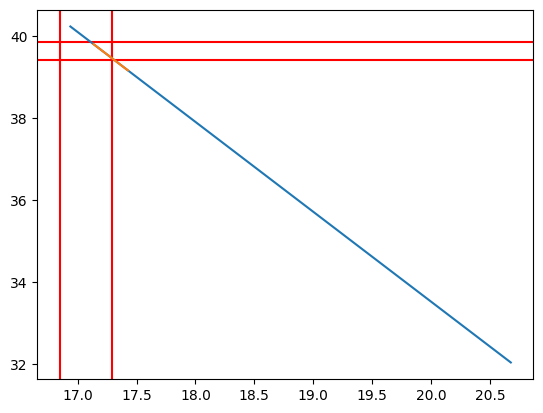

In [7]:

plt.axvline(pixels_x[0] + params.pixel_pitch - params.pixel_pitch/2, color='r')
plt.axvline(pixels_x[0] + params.pixel_pitch + params.pixel_pitch/2, color='r')
plt.axhline(pixels_y[0] + params.pixel_pitch - params.pixel_pitch/2, color='r')
plt.axhline(pixels_y[0] + params.pixel_pitch + params.pixel_pitch/2, color='r')
plt.plot((start[0][0], end[0][0]), (start[0][1], end[0][1]))
plt.plot((new_start[0][0], new_end[0][0]), (new_start[0][1], new_end[0][1]))

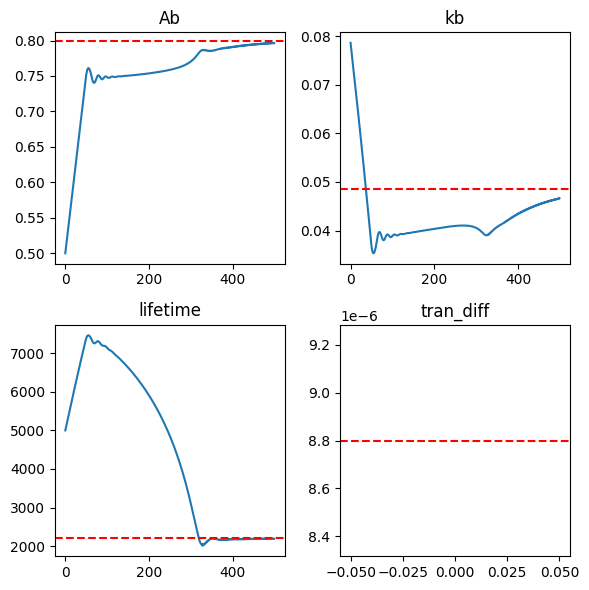

In [6]:
nrows, ncols = 2, 2
fig, axs = plt.subplots(2, 2, figsize=(3*nrows, 3*ncols))

for it, key in enumerate(to_propagate):
    i = it//ncols
    j = it%ncols

    ax = axs[i, j]
    ax.plot(flat_history[key])
    ax.axhline(getattr(ref_params, key), linestyle='dashed', color='red')
    ax.set_title(key)
fig.tight_layout()

In [8]:


t = jnp.repeat(jnp.arange(0, 200), 200*200)
t0 = jnp.repeat(jnp.arange(0, 200), 200*200)
x = jnp.repeat(jnp.linspace(0, 1, 200), 200*200)
y = jnp.repeat(jnp.linspace(0, 1, 200), 200*200)

# %timeit current_model(t, t0, x, y).block_until_ready()

In [5]:
%timeit simulate(params, tracks, fields)

3.61 ms ± 8.66 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
def diff_arange(start, end):
    return jnp.flip(jnp.stack([end-j-1. for j in range((end-start))]), axis=0)
diff_arange(0, 10)

Array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32, weak_type=True)

In [34]:
# from larndsim.consts_jax import StaticParams, VaryingParams, Params
from larndsim.drifting_jax import compute_drift

# params = {
#     "eField": 0.50,
#     "Ab": 0.8,
#     "kb": 0.0486,
#     "vdrift": 0.1648 ,
#     "lifetime": 2.2e3,
#     "long_diff": 4.0e-6,
#     "tran_diff": 8.8e-6,
# }

tracks, fields = load_data()
quencher = quench()
drifter = drift()
drifter.load_detector_properties("/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/detector_properties/module0.yaml",
                             "/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")


# static_params = StaticParams(jnp.asarray(drifter.tpc_borders))
# static_params = StaticParams(drifter.tpc_borders)
# static_params = StaticParams(8)
# fit_params = VaryingParams(**params)

# pix = pixels_from_track()
# pix.load_detector_properties("/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/detector_properties/module0.yaml",
#                              "/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")


ref_tracks = quencher.quench(params, tracks, 2, fields)
# ref_tracks = drifter.drift(params, ref_tracks, fields)
# ref_tracks = compute_drift(fit_params, static_params, ref_tracks, fields=fields)

def next_loss(fit_params, static_params, tracks_ref, tracks):
    new_tracks = quencher.quench(fit_params, tracks, 2, fields)
    # new_tracks = drifter.drift(params, new_tracks, fields)
    # new_tracks = compute_drift(fit_params, static_params, new_tracks, fields)
    return loss(new_tracks, tracks_ref, fields)

In [7]:
from flax import struct

[autoreload of numpy.core.multiarray failed: Traceback (most recent call last):
  File "/home/pgranger/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/pgranger/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/pgranger/.local/lib/python3.10/site-packages/numpy/core/multiarray.py", line 16, in <module>
    from ._multiarray_umath import (
ImportError: cannot import name 'fastCopyAndTranspose' from 'numpy.core._multiarray_umath' (/home/pgranger/.local/lib/python3.10/site-packages/numpy/cor

In [36]:
jax.devices()

[cuda(id=0)]

In [37]:
lr = 2e-8
modified_params = {
    "eField": 0.50,
    "Ab": 0.5,
    "kb": 0.0286,
    "vdrift": 0.1648,
    "lifetime": 5e3,
    "long_diff": 4.0e-6,
    "tran_diff": 8.8e-6,
}

history = {
    "eField": [],
    "Ab": [],
    "kb": [] ,
    "vdrift": [],
    "lifetime": [],
    "long_diff": [],
    "tran_diff": [],
    "loss": []
}

to_propagate = ["Ab", "kb", "lifetime"]

for i in tqdm(range(1000)):
    for key, value in modified_params.items():
        history[key].append(value)
    loss_val, grad_val = value_and_grad(next_loss, (0))(modified_params, ref_tracks, tracks)
    for key, value in modified_params.items():
        if key in to_propagate:
            modified_params[key] = value - history[key][0]**2 * grad_val[key]*lr
    history['loss'].append(loss_val)
    # print(f"{i}: {modified_params['Ab']}")

  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: next_loss() missing 1 required positional argument: 'tracks'

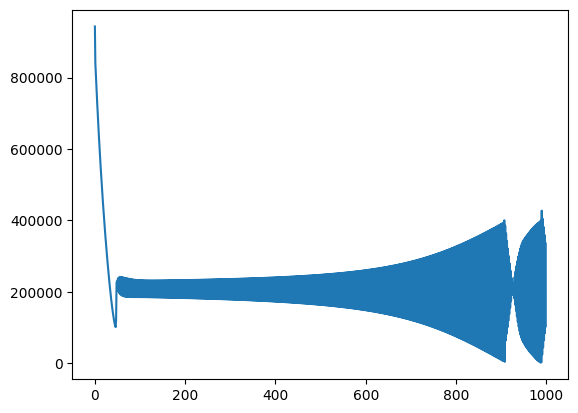

In [110]:
plt.plot(history['loss'])

In [152]:
#Testing static parameters with jax

def jit_params(f, C, static_argnames=[]):
    def _f(var_params, static_params, *args, **kwargs):
        params = C(*(var_params + static_params))
        return f(params, *args, **kwargs)
    if not isinstance(static_argnames, list):
        static_argnames = [static_argnames]
    static_argnames.append('static_params')
    return jit(_f, static_argnames=static_argnames)


params = {
    'a': 8.,
    'b': 4.2
}

static_params ={
    'N': 160,
    'M': 48
}

from collections import namedtuple

StaticParams = namedtuple('StaticParams', ['N', 'M'])
Params = namedtuple('StaticParams', ['a', 'b'])
C = namedtuple("C", StaticParams._fields + Params._fields)

static_params = StaticParams(160, 48)
params = Params(8., 4.2)

# @partial(jit, static_argnums=(1,))
# @jit
@partial(jit_params, C=C, static_argnames='cst')
def test_function(pars, cst):
    return pars.a*pars.M - pars.b*pars.N + cst

cst = 42

print(value_and_grad(test_function)(params, static_params, cst))
make_jaxpr(test_function)(params, static_params, cst)

(Array(330., dtype=float32, weak_type=True), StaticParams(a=Array(-48., dtype=float32, weak_type=True), b=Array(160., dtype=float32, weak_type=True)))


{ lambda ; a:f32[] b:f32[] c:i32[] d:i32[] e:i32[]. let
    f:f32[] = pjit[
      jaxpr={ lambda ; g:i32[] h:i32[] i:f32[] j:f32[] k:i32[]. let
          l:f32[] = convert_element_type[new_dtype=float32 weak_type=True] g
          m:f32[] = mul l j
          n:f32[] = convert_element_type[new_dtype=float32 weak_type=True] h
          o:f32[] = mul n i
          p:f32[] = sub m o
          q:f32[] = convert_element_type[new_dtype=float32 weak_type=True] k
          r:f32[] = add p q
        in (r,) }
      name=_f
    ] c d a b e
  in (f,) }

In [ ]:
make_jaxpr(tracks_current)(ref_params, pixels)

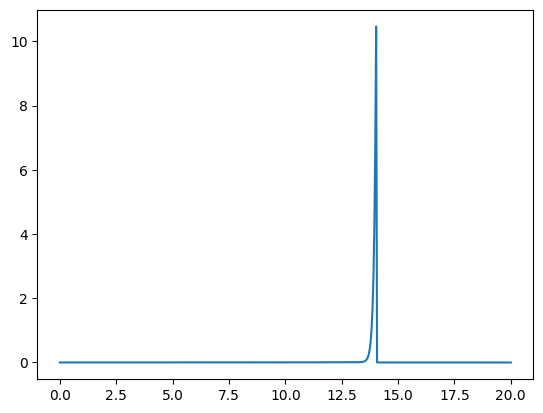

In [19]:
from larndsim.detsim_jax import current_model

t0 = 10
x = 0.4434/2
y = 0.4434/2
t = jnp.linspace(0, 20, 500)

current = current_model(t, t0, x, y)

plt.plot(t, current)

In [19]:
start = jnp.stack([tracks[:, fields.index("x_start")],
                    tracks[:, fields.index("y_start")],
                    tracks[:, fields.index("z_start")]], axis=1)
end = jnp.stack([tracks[:, fields.index("x_end")],
                tracks[:, fields.index("y_end")],
                tracks[:, fields.index("z_end")]], axis=1)

segment = end - start
length = jnp.linalg.norm(segment, ord=2, axis=1)
jnp.sum(length)/0.001

Array(759186.1, dtype=float32)

In [6]:
from larndsim.detsim_jax import current_model

npixels = 1000

size = 100000
key = random.PRNGKey(42)
pID = random.randint(key, (size, 1), 0, 1000)
key, _ = jax.random.split(key)
dx = random.uniform(key, (size, 1), jnp.float32, 0, 3)
key, _ = jax.random.split(key)
dy = random.uniform(key, (size, 1), jnp.float32, 0, 3)
key, _ = jax.random.split(key)
t0 = random.uniform(key, (size, 1), jnp.float32, 0., 100.)
t = jnp.arange(0, 100, 0.1).reshape((1, 1000)).repeat(size, axis=0)
current = current_model(t + t0, t0, dx, dy)
current

Array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.3444761e-03, -2.3140118e-03, -2.2839436e-03],
       [ 8.0599263e-04,  8.0823014e-04,  8.1047387e-04, ...,
        -3.6190182e-09, -3.5391912e-09, -3.4611185e-09]], dtype=float32)

0.4434

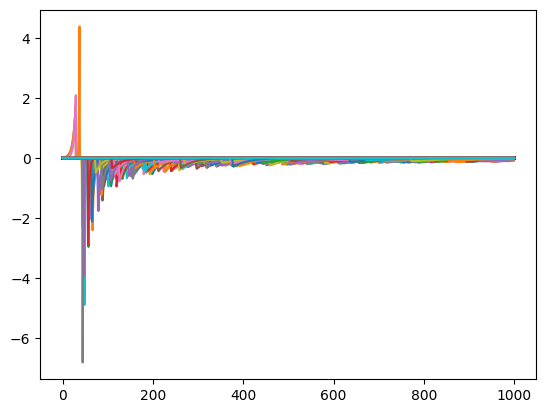

In [8]:
plt.plot(current[:1000, :].T);

In [22]:
unique_pixels = jnp.unique(pID)


NameError: name 'pID' is not defined

In [21]:
from jax.experimental.sparse import BCOO
import jax.numpy as jnp

size = 100000000000000

data = jnp.array([1., 3., 5.])
indices = jnp.array([[0],
                     [1],
                     [2]])
indices2 = jnp.array([[size - 10],
                     [size - 5000],
                     [size - 10000]])
mat = BCOO((data, indices), shape=(size,))
mat2 = BCOO((data, indices2), shape=(size,))
mat.update_layout()

BCOO(float32[100000000000000], nse=6)

In [66]:


tracks, fields = load_data()
tracks = filter_tracks(np.array(tracks), fields)
chopped = chop_tracks(tracks, fields)

18953


100%|██████████| 1089/1089 [00:00<00:00, 15147.21it/s]


(759256, 22)

In [65]:
tracks.shape

(1089, 22)